<a href="https://colab.research.google.com/github/Amirbn73/Image-Segmentation/blob/main/Aerial_Image_Segmentation_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=6c8a0d2a44170b6e52b39728265fd016f972d2cf06f6eb541852511b90b347a2
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=b230ef1373a7a66bec03724466cdfb882b12c0e4aaeee75293e04c8e73cf736d
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

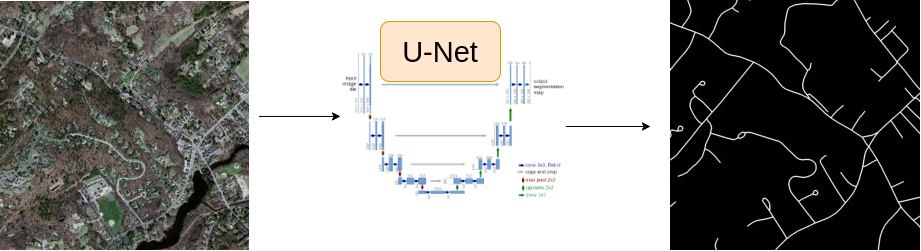

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411 (from 1)
Receiving objects: 100% (411/411), 851.74 MiB | 24.22 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset'
DEVICE = 'cuda'

EPOCHS = 25
BATCH_SIZE = 8
IMAGE_SIZE = 512
LEARNING_RATE = 0.003

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [7]:
df.shape

(199, 2)

In [8]:
idx = 52
row = df.iloc[idx]
image_path = DATA_DIR + '/' + row.images
mask_path = DATA_DIR + '/' + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

In [9]:
image_path

'/content/Road_seg_dataset/images/11278765_15.png'

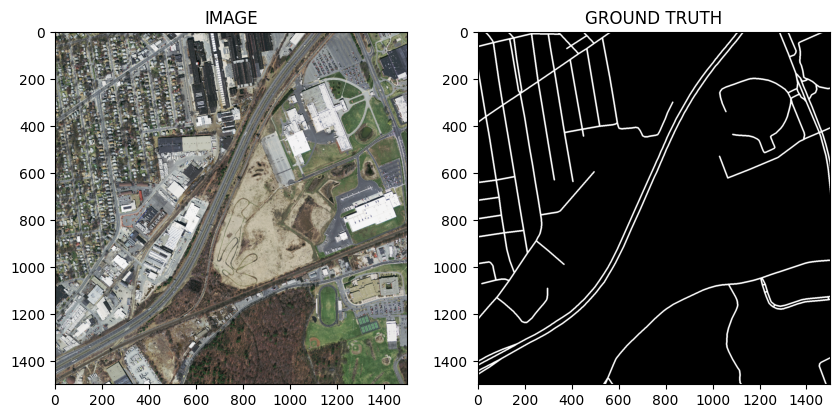

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [11]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [12]:
import albumentations as A

In [13]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])
def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [14]:
from torch.utils.data import Dataset

In [15]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = DATA_DIR + '/' + row.images
    mask_path = DATA_DIR + '/' + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask))

    return image, mask

In [16]:
trainset = SegmentationDataset(train_df, augmentations=get_train_augs())
validset = SegmentationDataset(valid_df, augmentations=get_valid_augs())

In [17]:
print(f"Total Train Images : {len(trainset)}")
print(f"Total Valid Images : {len(validset)}")

Total Train Images : 159
Total Valid Images : 40


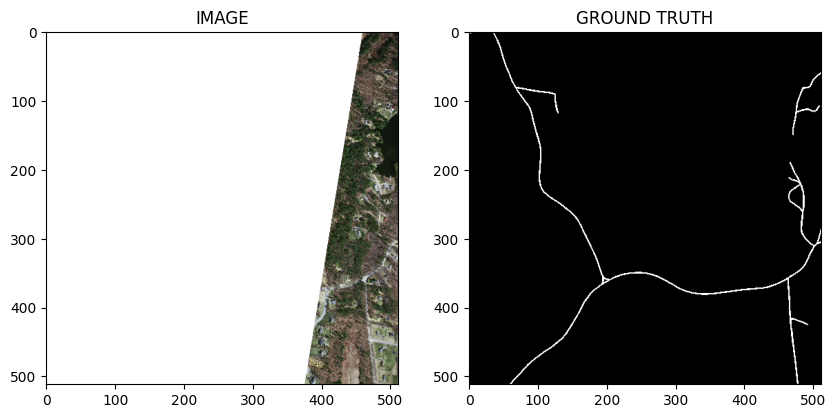

In [18]:
idx = 42

image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [19]:
from torch.utils.data import DataLoader

In [20]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [21]:
print(f"Total Train Batches : {len(trainloader)}")
print(f"Total Valid Batches : {len(validloader)}")

Total Train Batches : 20
Total Valid Batches : 5


In [22]:
for image, mask in trainloader:
  print(image.shape)
  print(mask.shape)
  break

torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [23]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [24]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation = None
    )

  def forward(self, images, masks=None):

    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [25]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 46.1MB/s]


SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

# Task 7 : Create Train and Validation Function

In [26]:
def train(dataloader, model, optimizer):

  model.train()

  total_loss = 0

  for images, masks in tqdm(trainloader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()

    logits, loss = model(images, masks)
    loss.backward()

    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(trainloader)

In [27]:
def eval_fn(dataloader, model):

  model.eval()

  total_loss = 0
  with torch.no_grad():
    for images, masks in tqdm(trainloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)


      logits, loss = model(images, masks)

      total_loss += loss.item()

    return total_loss / len(trainloader)

# Task 8 : Train Model

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [29]:
best_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), 'best_model.pth')
    print('Saved Best Model!')
    best_loss = valid_loss

    print(f"Epoch : {i+1}")
    print(f"Train Loss : {train_loss:.4f}")
    print(f"Valid Loss : {valid_loss:.4f}")

100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


Saved Best Model!
Epoch : 1
Train Loss : 1.0288
Valid Loss : 0.9329


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Saved Best Model!
Epoch : 2
Train Loss : 0.7491
Valid Loss : 0.7575


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Saved Best Model!
Epoch : 3
Train Loss : 0.7049
Valid Loss : 0.7213


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Saved Best Model!
Epoch : 4
Train Loss : 0.6766
Valid Loss : 0.6631


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Saved Best Model!
Epoch : 6
Train Loss : 0.6467
Valid Loss : 0.6375


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Saved Best Model!
Epoch : 7
Train Loss : 0.6360
Valid Loss : 0.6271


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Saved Best Model!
Epoch : 8
Train Loss : 0.6306
Valid Loss : 0.6166


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Saved Best Model!
Epoch : 10
Train Loss : 0.6224
Valid Loss : 0.6164


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Saved Best Model!
Epoch : 11
Train Loss : 0.6119
Valid Loss : 0.5972


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Saved Best Model!
Epoch : 13
Train Loss : 0.6057
Valid Loss : 0.5866


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Saved Best Model!
Epoch : 16
Train Loss : 0.5909
Valid Loss : 0.5745


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Saved Best Model!
Epoch : 18
Train Loss : 0.5781
Valid Loss : 0.5653


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Saved Best Model!
Epoch : 19
Train Loss : 0.5775
Valid Loss : 0.5579


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Saved Best Model!
Epoch : 23
Train Loss : 0.5846
Valid Loss : 0.5509


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


# Task 9 : Inference

In [32]:
idx = 1

model.load_state_dict(torch.load('/content/best_model.pth'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(ch, h, w) -> (b, ch, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

<ipython-input-32-be33f7150fee>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pth'))


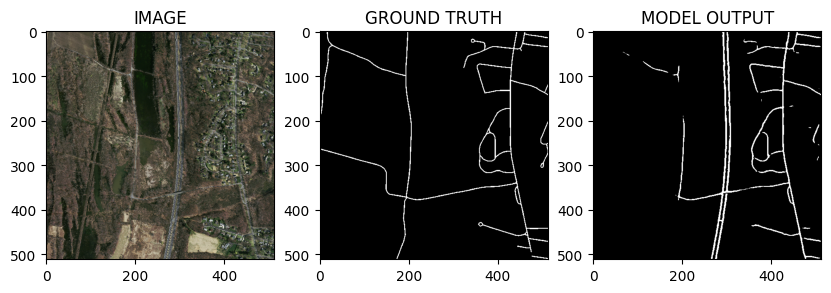

In [33]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))